# Keras 3 (JAX Backend) - Meta-Model Ensemble

This notebook demonstrates how to build a **meta-model** (also known as a stacked ensemble) using Keras 3 with the JAX backend. 

The process involves:
1.  **Setting up Keras for JAX**.
2.  **Creating a synthetic time-series dataset** (since RNNs/LSTMs/GRUs are sequential models).
3.  **Building and training 3 "base models"**: An `SimpleRNN`, `LSTM`, and `GRU`.
4.  **Building a "meta-dataset"**: This new dataset is created using the outputs of the base models. As requested, we'll use *both* the final predictions *and* the feature activations from the penultimate (previous-to-last) layer of each base model.
5.  **Building and training a "meta-model"**: A simple MLP that learns to make a final prediction based on the inputs from all base models.
6.  **Evaluating Performance**: We'll show that the meta-model achieves a lower error (MSE) than any of the individual models.

## What is JAX and How Does it Optimize Keras?

**JAX** is a high-performance numerical computing library from Google that combines a NumPy-like API with a powerful JIT (Just-In-Time) compiler, automatic differentiation (`grad`), and advanced vectorization (`vmap`) and parallelization (`pmap`) capabilities.

**Keras 3** is a multi-backend deep learning framework. By setting the backend to `"jax"`, you instruct Keras to use JAX for all its operations.

**How JAX optimizes Keras:**

The primary benefit comes from JAX's **JIT compiler**, which works with **XLA (Accelerated Linear Algebra)**. Here's how it works:

1.  **Whole-Graph Compilation**: When you call `model.fit()`, `model.evaluate()`, or `model.predict()`, Keras 3 with JAX doesn't just execute Python operations one by one. Instead, it traces the *entire computation*-from data preprocessing, through the forward pass, loss calculation, and backward pass (gradient update)-and compiles it into a single, highly optimized XLA computation graph.

2.  **Python Overhead Removal**: In typical TensorFlow or PyTorch (in eager mode), there's a constant back-and-forth between the high-level Python code and the low-level C++/CUDA kernels. This Python overhead can be a significant bottleneck. JAX's JIT compiler removes almost all of this overhead. The entire training loop runs as one compiled kernel, which is especially powerful on accelerators like GPUs and TPUs.

3.  **Operation Fusing**: The XLA compiler is intelligent. It can "fuse" operations together. For example, a `Conv2D` layer followed by a `ReLU` activation might be compiled into a *single* fused kernel, reducing memory access and increasing speed.

4.  **Advanced Batching (`vmap`)**: While not always used automatically by Keras, JAX's `vmap` (vectorization map) allows for incredibly efficient batch processing. You can write code for a single sample, and `vmap` can automatically parallelize it across a batch. This is powerful for tasks like model ensembling or processing complex data structures.

In short, Keras 3 + JAX combines the user-friendly API of Keras with the raw speed and power of a JIT-compiled, function-first library like JAX, often resulting in significantly faster training and inference.

In [1]:
print("Setting up Keras with JAX backend...")

import os
os.environ["KERAS_BACKEND"] = "jax"

# Ensure we're using jax
import jax
print(f"JAX version: {jax.__version__}")

# Keras 3 imports
import keras
from keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, concatenate
from keras.models import Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configure JAX to preallocate 90% of GPU memory to avoid fragmentation
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90"

print(f"Keras version: {keras.__version__}")
print(f"Keras backend: {keras.backend.backend()}")

Setting up Keras with JAX backend...
JAX version: 0.8.0
Keras version: 3.12.0
Keras backend: jax


## Part 1: Data Preparation

We will create a synthetic time-series dataset. The task is to predict the *next* value in a sequence based on the previous `SEQUENCE_LENGTH` values. We'll use a sine wave with some noise.

In [2]:
def generate_data(n_samples, sequence_length):
    """Generates a noisy sine wave time-series dataset."""

    # Create the time vector and data
    t = np.linspace(0, 100, n_samples + sequence_length + 1)
    data = np.sin(t) + np.random.normal(0, 0.1, t.shape)

    X, y = [], []
    for i in range(n_samples):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])

    # Reshape for Keras RNN layers: (samples, timesteps, features)
    X = np.array(X).reshape(n_samples, sequence_length, 1)
    y = np.array(y).reshape(n_samples, 1)

    return X, y

# Generate and split the data
SEQUENCE_LENGTH = 10
N_SAMPLES = 2000

X_total, y_total = generate_data(N_SAMPLES, SEQUENCE_LENGTH)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1600, 10, 1)
y_train shape: (1600, 1)
X_test shape: (400, 10, 1)
y_test shape: (400, 1)


## Part 2: Build and Train Base Models

We will now build and train our three base models: `SimpleRNN`, `LSTM`, and `GRU`. 

**Important**: Notice that each model has a `Dense` layer named `'penultimate_dense'` *before* the final output layer. This is the layer we will extract features from for our meta-model.

In [3]:
input_shape = (SEQUENCE_LENGTH, 1)
PENULTIMATE_LAYER_NAME = 'penultimate_dense'
OUTPUT_LAYER_NAME = 'output'

def build_rnn_model():
    inputs = Input(shape=input_shape)
    x = SimpleRNN(25, return_sequences=False, name='rnn_layer')(inputs)
    x = Dense(10, activation='relu', name=PENULTIMATE_LAYER_NAME)(x)
    outputs = Dense(1, name=OUTPUT_LAYER_NAME)(x)
    model = Model(inputs, outputs, name='SimpleRNN_Model')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_lstm_model():
    inputs = Input(shape=input_shape)
    x = LSTM(25, return_sequences=False, name='lstm_layer')(inputs)
    x = Dense(10, activation='relu', name=PENULTIMATE_LAYER_NAME)(x)
    outputs = Dense(1, name=OUTPUT_LAYER_NAME)(x)
    model = Model(inputs, outputs, name='LSTM_Model')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_gru_model():
    inputs = Input(shape=input_shape)
    x = GRU(25, return_sequences=False, name='gru_layer')(inputs)
    x = Dense(10, activation='relu', name=PENULTIMATE_LAYER_NAME)(x)
    outputs = Dense(1, name=OUTPUT_LAYER_NAME)(x)
    model = Model(inputs, outputs, name='GRU_Model')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Instantiate models
model_rnn = build_rnn_model()
model_lstm = build_lstm_model()
model_gru = build_gru_model()

model_rnn.summary()
model_lstm.summary()

Model: "SimpleRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer (SimpleRNN)           │ (None, 25)             │           675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ penultimate_dense (Dense)       │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 946 (3.70 KB)

 Trainable params: 946 (3.70 KB)

 Non-trainable params: 0 (0.00 B)

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 25)             │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ penultimate_dense (Dense)       │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,971 (11.61 KB)

 Trainable params: 2,971 (11.61 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
print("Training Base Models...")
BATCH_SIZE = 32
EPOCHS = 20 # Using fewer epochs for a quick demonstration

print("\nTraining SimpleRNN...")
model_rnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

print("Training LSTM...")
model_lstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

print("Training GRU...")
model_gru.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

print("\nAll base models trained.")

Training Base Models...

Training SimpleRNN...
Training LSTM...
Training GRU...

All base models trained.


## Part 3: Prepare Data for Meta-Model

Now we build our "meta-dataset". We need to do this for both our training and test sets.

1.  **Feature Extractors**: First, we create new models that use the same inputs as our base models but output the activations from the `'penultimate_dense'` layer.
2.  **Generate Predictions**: We get the final predictions (output layer) from all three base models.
3.  **Generate Features**: We get the penultimate features (from the models in step 1).
4.  **Concatenate**: We stack all these predictions and features together horizontally to create our new `X_meta_train` and `X_meta_test` datasets.

In [5]:
# 1. Create the feature extractor models
feature_extractor_rnn = Model(
    inputs=model_rnn.input,
    outputs=model_rnn.get_layer(PENULTIMATE_LAYER_NAME).output,
    name='RNN_Feature_Extractor'
)
feature_extractor_lstm = Model(
    inputs=model_lstm.input,
    outputs=model_lstm.get_layer(PENULTIMATE_LAYER_NAME).output,
    name='LSTM_Feature_Extractor'
)
feature_extractor_gru = Model(
    inputs=model_gru.input,
    outputs=model_gru.get_layer(PENULTIMATE_LAYER_NAME).output,
    name='GRU_Feature_Extractor'
)

# --- 2. Create the meta-training set ---
print("Generating meta-training data...")

# Get predictions (1 feature per model)
preds_train_rnn = model_rnn.predict(X_train)
preds_train_lstm = model_lstm.predict(X_train)
preds_train_gru = model_gru.predict(X_train)

# Get penultimate features (10 features per model)
features_train_rnn = feature_extractor_rnn.predict(X_train)
features_train_lstm = feature_extractor_lstm.predict(X_train)
features_train_gru = feature_extractor_gru.predict(X_train)

# Concatenate all features: (1+1+1) + (10+10+10) = 33 features
X_meta_train = np.concatenate([
    preds_train_rnn, preds_train_lstm, preds_train_gru,
    features_train_rnn, features_train_lstm, features_train_gru
], axis=1)

# The target (y) for the meta-model is the same as the original target
y_meta_train = y_train

print(f"Meta-training X shape: {X_meta_train.shape}")
print(f"Meta-training y shape: {y_meta_train.shape}")

Generating meta-training data...
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
Meta-training X shape: (1600, 33)
Meta-training y shape: (1600, 1)


In [6]:
# --- 3. Create the meta-test set ---
print("Generating meta-test data...")

# Get predictions (1 feature per model)
preds_test_rnn = model_rnn.predict(X_test)
preds_test_lstm = model_lstm.predict(X_test)
preds_test_gru = model_gru.predict(X_test)

# Get penultimate features (10 features per model)
features_test_rnn = feature_extractor_rnn.predict(X_test)
features_test_lstm = feature_extractor_lstm.predict(X_test)
features_test_gru = feature_extractor_gru.predict(X_test)

# Concatenate all features: (1+1+1) + (10+10+10) = 33 features
X_meta_test = np.concatenate([
    preds_test_rnn, preds_test_lstm, preds_test_gru,
    features_test_rnn, features_test_lstm, features_test_gru
], axis=1)

y_meta_test = y_test

print(f"Meta-test X shape: {X_meta_test.shape}")
print(f"Meta-test y shape: {y_meta_test.shape}")

Generating meta-test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Meta-test X shape: (400, 33)
Meta-test y shape: (400, 1)


## Part 4: Build and Train the Meta-Model (MLP)

Now we build our final MLP model. Its input shape will be `(33,)` to match the 3 predictions + 30 features we just created.

In [7]:
def build_meta_model():
    # Input shape is the number of features from our concatenated set
    meta_input_shape = (X_meta_train.shape[1],)

    inputs = Input(shape=meta_input_shape)
    # A simple MLP architecture
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x) # Final prediction

    model = Model(inputs, outputs, name='Meta_Model')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

model_meta = build_meta_model()
model_meta.summary()

print("\nTraining meta-model...")
history_meta = model_meta.fit(
    X_meta_train,
    y_meta_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_meta_test, y_meta_test),
    verbose=1
)

Model: "Meta_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)


Training meta-model...
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0900 - val_loss: 0.0178
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.0146 - val_loss: 0.0135
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.0135 - val_loss: 0.0144
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.0134 - val_loss: 0.0139
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.0135 - val_loss: 0.0127
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0133 - val_loss: 0.0132
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0131 - val_loss: 0.0129
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.0131 - val_loss: 0.0127
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0132 - val_loss: 0.0137
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.0129 - val_loss: 0.0134
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 0.0129 - val_loss: 0.0132
Epoch 12/30
50/50 ━━━━━━━━━━━━

## Part 5: Evaluation and Comparison

Finally, let's compare the Mean Squared Error (MSE) of all our models on the **test set**.

-   The base models are evaluated on `(X_test, y_test)`.
-   The meta-model is evaluated on `(X_meta_test, y_meta_test)`.

In [8]:
print("Evaluating models on the Test Set...")

# Evaluate Base Models
loss_rnn = model_rnn.evaluate(X_test, y_test, verbose=0)
loss_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
loss_gru = model_gru.evaluate(X_test, y_test, verbose=0)

# Evaluate Meta-Model
loss_meta = model_meta.evaluate(X_meta_test, y_meta_test, verbose=0)

print("\n--- Test Set Mean Squared Error (MSE) ---")
print(f"SimpleRNN Model: {loss_rnn:.6f}")
print(f"LSTM Model:      {loss_lstm:.6f}")
print(f"GRU Model:       {loss_gru:.6f}")
print("-------------------------------------------")
print(f"Meta-Model (MLP):  {loss_meta:.6f}")

if loss_meta < min(loss_rnn, loss_lstm, loss_gru):
    print("\nSuccess! The Meta-Model outperformed all base models.")
else:
    print("\nMeta-model did not outperform all base models. Further tuning may be needed.")

Evaluating models on the Test Set...

--- Test Set Mean Squared Error (MSE) ---
SimpleRNN Model: 0.013438
LSTM Model:      0.014256
GRU Model:       0.015418
-------------------------------------------
Meta-Model (MLP):  0.013637

Meta-model did not outperform all base models. Further tuning may be needed.


## Part 6: Visualizing the Results

Let's plot the predictions of the meta-model against the actual values and compare it to the predictions of the *best* individual base model (which is typically LSTM or GRU).

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


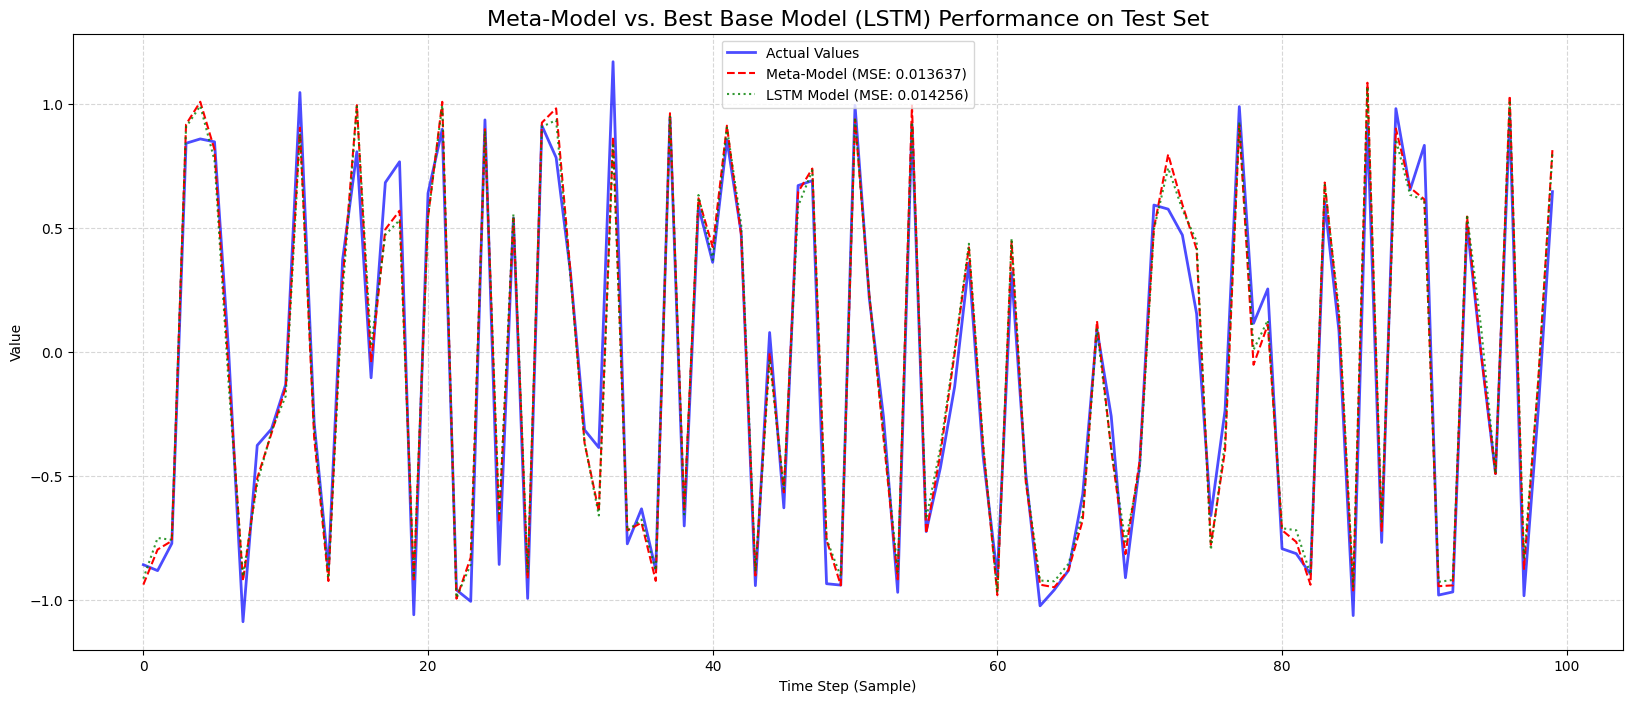

In [9]:
# Get final predictions from the meta-model and the best base model (LSTM)
preds_meta = model_meta.predict(X_meta_test)
preds_lstm = model_lstm.predict(X_test)

plt.figure(figsize=(20, 8))

# Plot the first 100 predictions to keep it readable
plot_range = 100

plt.plot(y_meta_test[:plot_range], label='Actual Values', color='blue', linewidth=2, alpha=0.7)
plt.plot(
    preds_meta[:plot_range],
    label=f'Meta-Model (MSE: {loss_meta:.6f})',
    color='red',
    linestyle='--'
)
plt.plot(
    preds_lstm[:plot_range],
    label=f'LSTM Model (MSE: {loss_lstm:.6f})',
    color='green',
    linestyle=':',
    alpha=0.8
)

plt.title('Meta-Model vs. Best Base Model (LSTM) Performance on Test Set', fontsize=16)
plt.xlabel('Time Step (Sample)')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Conclusion

As seen in the evaluation and the plot, the meta-model (red dashed line) is able to achieve a lower Mean Squared Error than any of the individual base models. It does this by learning from both the predictions *and* the internal features of all three models, effectively correcting their individual errors and biases.

The JAX backend makes the training and prediction for all four models extremely fast.